# E-commerce Project

A hypothetical e-commerce company 'X' serves as a third-party retailer, bridging online shoppers with sellers. It also has its own production line of goods, & has a physical brick & mortar store in Singapore selling some of their own products. It is vital for 'X' to be ahead of customers’ buying patterns & current trends, due to strong competition from other e-commerce companies with similarly competitive pricing & strong marketing.

The first part of this project uses data to recommend a loyalty program, to tier customers so that they can be rewarded gradually for spending more. Next, a forecasting model will be created so that the supply chain department can better manage the available inventory space & ensure that a future increase/decrease in demand can be accounted for. Lastly, a command line user interface will be programmed to allow easy summary pull outs of past data & generate future demands, serving as a user interface that all employees can access.

**Table of Contents:**
1. [Data Conversion](#1)
2. [Data Cleaning](#2)
3. [Analysis & Solutions](#3)
    - 3.1 [Loyalty Program](#3.1)
    - 3.2 [Forecast](#3.2)
    - 3.3 [Command Line](#3.3)

In [2]:
import pandas as pd
import json
import csv
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import math

<a id='1'><h2><font color="salmon">&nbsp;1.</font><font color="salmon"> Data Conversion </font> </h2></a>

Loading & combining the given CSV & JSON datasets on "StockISN".

In [2]:
with open("cat_class.json", "r") as read_file:
    cat_class = json.load(read_file)

stockcards = []

with open("stockcards.csv", "r") as file_pointer:
    csv_pointer = csv.reader(file_pointer)
    for each in csv_pointer:
        stockcards.append(each)

for each in stockcards:
    for each_dict in cat_class:
        if each_dict["StockISN"] == each[10]:
            each.append(each_dict["CatCode"])

Creating a masterlist & writing it into a JSON file.

In [3]:
stockcards_master = []
stockcards_dict = {}
column_title = ['Date', 'Type', 'RefNo', 'SNO', 'Cur', 'TUPrice', 'ODAmt', 'Amt', 'Worth', 'Customer', 'StkISN', 'CatCode']

for list in stockcards:
    for i in range(0, len(list)):
        stockcards_dict[column_title[i]] = list[i]
    stockcards_master.append(stockcards_dict.copy())
    
with open("stockcards.json", "w") as write_file:
    json.dump(stockcards_master, write_file, indent = 6)

In [4]:
with open("stockcards.json", "w") as write_file:
    json.dump(stockcards_master, write_file, indent = 6)

<a id='2'><h2><font color="salmon">&nbsp;2.</font><font color="salmon"> Data Cleaning </font> </h2></a>

In [5]:
# Importing the JSON data

data = pd.read_json("stockcards.json")

In [6]:
# Dropping useless row & columns

data = data.drop(0) # To remove the first row of useless data
data.pop("ODAmt") # To remove the ODAmt column
data.pop("Worth") # To remove the Worth column

1           -2542
2           -2819
3           -2855
4           -2636
5           -5279
           ...   
56082    -1175.91
56083     -296.03
56084     -307.67
56085       -2500
56086      -964.8
Name: Worth, Length: 56086, dtype: object

In [7]:
# Cleaning the Date column by only keeping the records from 5 years before 2019

for each in range(1, len(data)):
    if "2011" in str(data["Date"][each]):
        data = data.drop(each)
    elif "2012" in str(data["Date"][each]):
        data = data.drop(each)
    elif "2013" in str(data["Date"][each]):
        data = data.drop(each)
    elif "2014" in str(data["Date"][each]):
        data = data.drop(each)

data.Date = pd.to_datetime(data.Date)
data.Date = data.Date.dt.strftime('%d/%m/%Y') # Reformat date into dd/mm/yyyy

In [8]:
# Cleaning the Currency column

data.Cur = data.Cur.fillna("S$") # Replace empty cells with S$
data.loc[data.Cur == "", "Cur"] = "S$" # Replace “” with S$
data.loc[data.Cur == "SIN", "Cur"] = "S$" # Replace SIN with S$
data.loc[data.Cur == "SGD", "Cur"] = "S$" # Replace SGD with S$
data.loc[data.Cur == "US", "Cur"] = "USD$" # Replace US with USD$
data.loc[data.Cur == "USD", "Cur"] = "USD$" # Replace USD with USD$
data.loc[data.Cur == "US$", "Cur"] = "USD$" # Replace US$ with USD$

In [9]:
# Cleaning the RefNo & SNO columns

is_unique = data.RefNo.unique()
data = data.sort_values(["RefNo", "SNO"], ascending = [1, 1])

for refno in is_unique:
    x = data.loc[data.RefNo == refno, "SNO"].index
    y = []
    for each in range(1, len(x) + 1):
        y.append(each)
    for each in range(len(x)):
        data.loc[x[each],"SNO"] = y[each]

In [10]:
# Cleaning the StkISN column

data["StkISN"].replace("", np.nan, inplace = True) # Replacing "" with NA
data.dropna(subset = ["StkISN"], inplace = True) # Removing non-stock transactions

In [11]:
# Cleaning the Amount column

data.Amt = pd.to_numeric(data.Amt) # Change the dtype from object to float
data.Amt = data.Amt.abs() # Make the values absolute

In [12]:
# Cleaning the Customer column
data.reset_index(inplace = True)

data.Customer = data.Customer.fillna("CASH") # Replace empty cells with CASH
for each in range(len(data)):
    data.loc[each,"Customer"] = data.loc[each,"Customer"].upper().strip()
    x = data.loc[each,"Customer"]
    if x == "CASH":
        data = data.drop(each)
    if x == "RB01":
        data = data.drop(each) # Removing an anomaly

In [13]:
# Writing dataframe to CSV

data.pop("index")
data.to_csv("cleaned_data.csv", index = False)

<a id='3'><h2><font color="salmon">&nbsp;3.</font><font color="salmon"> Analysis & Solutions </font> </h2></a>

In [3]:
# Importing the data

clean = pd.read_csv("cleaned_data.csv")
clean.Date = pd.to_datetime(clean.Date, format = '%d/%m/%Y')
clean.Date = clean.Date.dt.strftime('%d/%m/%Y')

### Customer Buying Patterns

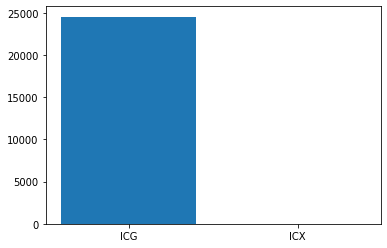

In [4]:
# Identifying purchase methods

purchase = {}
for index in range(len(clean)):
    key =  clean.loc[index, "Type"]
    if key not in purchase:
        purchase[key] = 1
    else:
        purchase[key] += 1
plt.bar(range(len(purchase)), list(purchase.values()), align = 'center')
plt.xticks(range(len(purchase)), list(purchase.keys()))
plt.show()

### Most Popular Products

Creating visualisations of the Top 15 & Bottom 15 most popular products yearly.

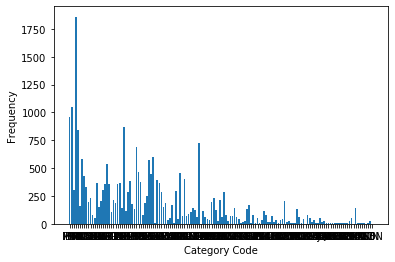

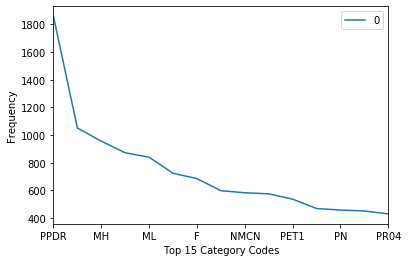

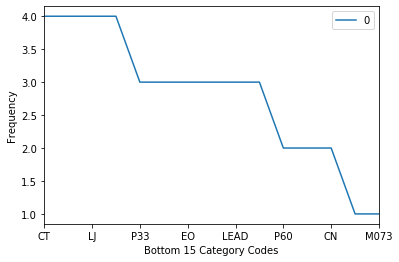

In [5]:
# Identifying category purchasing pattern 

catcode_unique = clean.CatCode.unique()
catcode = {}

for i in range(len(clean)):
    key = clean.loc[i, "CatCode"]
    for each in catcode_unique:
        if key == each:
            if key not in catcode:
                catcode[each] = 1
            else:
                catcode[each] += 1

plt.bar(range(len(catcode)), list(catcode.values()), align = 'center')
plt.xticks(range(len(catcode)), list(catcode.keys()))
plt.xlabel("Category Code")
plt.ylabel("Frequency")
plt.show() 

catcode_df = pd.DataFrame.from_dict(catcode, orient = 'index')

catcode_df.sort_values(by = 0, ascending = False).head(15).plot()
plt.xlabel("Top 15 Category Codes")
plt.ylabel("Frequency")
plt.show()

catcode_df.sort_values(by = 0, ascending = False).tail(15).plot()
plt.xlabel("Bottom 15 Category Codes")
plt.ylabel("Frequency")
plt.show()

In [6]:
# Sort by years

def group_year(year):
    group_yearlist = []
    for i in range(len(clean)):
        if clean.loc[i, "Date"][6:] == year:
            if i not in group_yearlist:
                group_yearlist.append(i)
                
    return group_yearlist

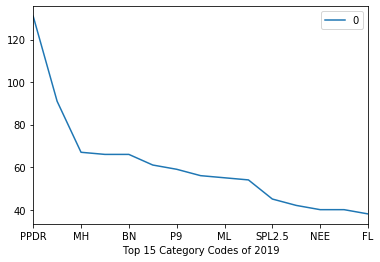

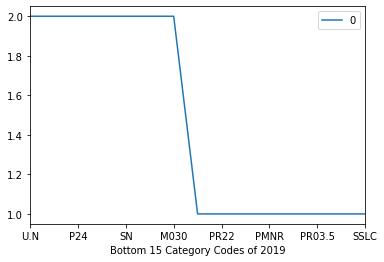

In [7]:
date2019 = group_year("2019")

catcode2019 = {}
for i in date2019:
    key = clean.loc[i, "CatCode"]
    for each in catcode_unique:
        if key == each:
            if key not in catcode2019:
                catcode2019[each] = 1
            else:
                catcode2019[each] += 1    

catcode2019_df = pd.DataFrame.from_dict(catcode2019, orient = 'index')

catcode2019_df.sort_values(by = 0, ascending = False).head(15).plot()
plt.xlabel("Top 15 Category Codes of 2019")
plt.show()
catcode2019_df.sort_values(by = 0, ascending = False).tail(15).plot()
plt.xlabel("Bottom 15 Category Codes of 2019")
plt.show()

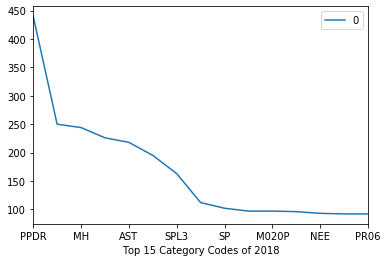

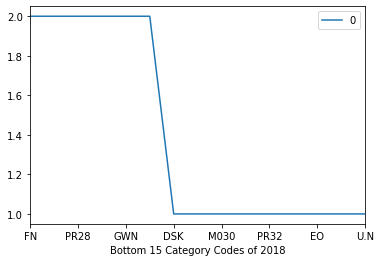

In [8]:
date2018 = group_year("2018")
catcode2018 = {}

for i in date2018:
    key = clean.loc[i, "CatCode"]
    for each in catcode_unique:
        if key == each:
            if key not in catcode2018:
                catcode2018[each] = 1
            else:
                catcode2018[each] += 1  

catcode2018_df = pd.DataFrame.from_dict(catcode2018, orient = 'index')

catcode2018_df.sort_values(by = 0, ascending = False).head(15).plot()
plt.xlabel("Top 15 Category Codes of 2018")
plt.show()
catcode2018_df.sort_values(by = 0, ascending = False).tail(15).plot()
plt.xlabel("Bottom 15 Category Codes of 2018")
plt.show()

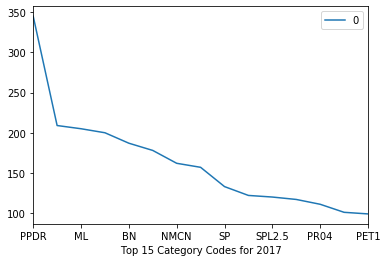

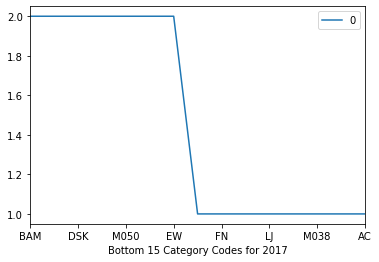

In [25]:
date2017 = group_year("2017")
catcode2017 = {}

for i in date2017:
    key = clean.loc[i, "CatCode"]
    for each in catcode_unique:
        if key == each:
            if key not in catcode2017:
                catcode2017[each] = 1
            else:
                catcode2017[each] += 1  

catcode2017_df = pd.DataFrame.from_dict(catcode2017, orient = 'index')

catcode2017_df.sort_values(by = 0, ascending = False).head(15).plot()
plt.xlabel("Top 15 Category Codes for 2017")
plt.show()
catcode2017_df.sort_values(by = 0, ascending = False).tail(15).plot()
plt.xlabel("Bottom 15 Category Codes for 2017")
plt.show()

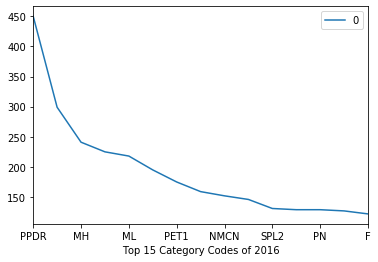

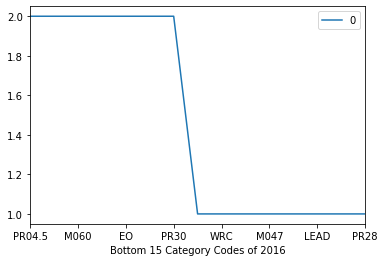

In [9]:
date2016 = group_year("2016")
catcode2016 = {}

for i in date2016:
    key = clean.loc[i, "CatCode"]
    for each in catcode_unique:
        if key == each:
            if key not in catcode2016:
                catcode2016[each] = 1
            else:
                catcode2016[each] += 1  

catcode2016_df = pd.DataFrame.from_dict(catcode2016, orient = 'index')

catcode2016_df.sort_values(by = 0, ascending = False).head(15).plot()
plt.xlabel("Top 15 Category Codes of 2016")
plt.show()
catcode2016_df.sort_values(by = 0, ascending = False).tail(15).plot()
plt.xlabel("Bottom 15 Category Codes of 2016")
plt.show()

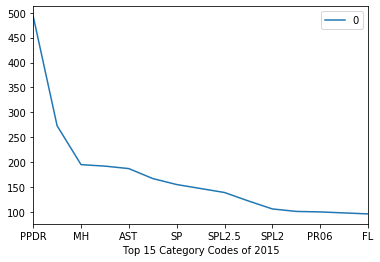

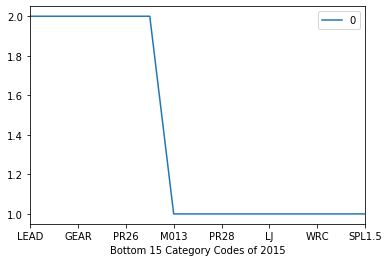

In [27]:
date2015 = group_year("2015")         
catcode2015 = {}

for i in date2015:
    key = clean.loc[i, "CatCode"]
    for each in catcode_unique:
        if key == each:
            if key not in catcode2015:
                catcode2015[each] = 1
            else:
                catcode2015[each] += 1 

catcode2015_df = pd.DataFrame.from_dict(catcode2015, orient = 'index')

catcode2015_df.sort_values(by = 0, ascending = False).head(15).plot()
plt.xlabel("Top 15 Category Codes of 2015")
plt.show()
catcode2015_df.sort_values(by = 0, ascending = False).tail(15).plot()
plt.xlabel("Bottom 15 Category Codes of 2015")
plt.show()

### Geographic Distribution


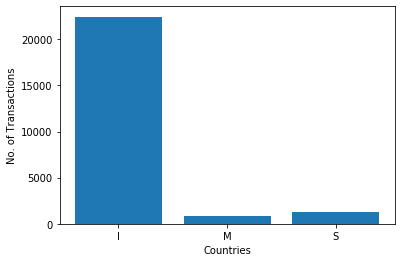

In [12]:
# Comparing the number of transactions per country

country = {}
for index in range(len(clean)):
    key =  clean.loc[index, "Customer"][0]
    if key not in country:
        country[key] = 1
    else:
        country[key] += 1
plt.bar(range(len(country)), list(country.values()), align = 'center')
plt.xticks(range(len(country)), list(country.keys()))
plt.xlabel("Countries")
plt.ylabel("No. of Transactions")
plt.show() 

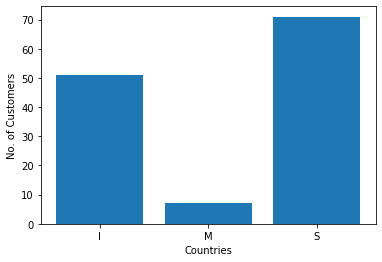

In [13]:
# Comparing the number of unique customers per country

customer_unique = clean.Customer.unique()
customer = {}

for each in customer_unique:
    if each[0] not in customer:
        customer[each[0]] = 1
    else:
        customer[each[0]] += 1

plt.bar(range(len(customer)), list(customer.values()), align = 'center')
plt.xticks(range(len(customer)), list(customer.keys()))
plt.xlabel("Countries")
plt.ylabel("No. of Customers")
plt.show() 

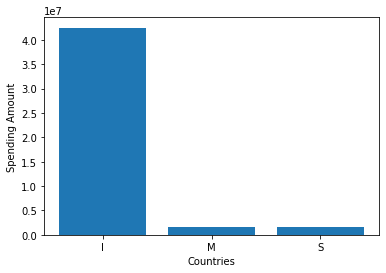

In [14]:
# Comparing the total amount spent per country

spending = {}

for index in range(len(clean)):
    key =  clean.loc[index, "Customer"][0]
    value = clean.loc[index, "Amt"]
    if key not in spending:
        spending[key] = value
    else:
        spending[key] += value
        
plt.bar(range(len(spending)), list(spending.values()), align = 'center')
plt.xticks(range(len(spending)), list(spending.keys()))
plt.xlabel("Countries")
plt.ylabel("Spending Amount")
plt.show() 

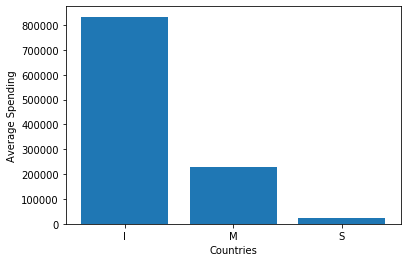

In [15]:
# Comparing the average speding per customer per country

avg_spending = {}

for each in customer.keys():
    avg_spending[each] = spending[each] / customer[each]
    
plt.bar(range(len(avg_spending)), list(avg_spending.values()), align = 'center')
plt.xticks(range(len(avg_spending)), list(avg_spending.keys()))
plt.xlabel("Countries")
plt.ylabel("Average Spending")
plt.show() 

<a id='3.1'><h3>3.1 Loyalty Program</h3></a>

To create a banding for the loyalty program which tiers the customers by Bronze, Silver, Gold in ascending order according to how much they had spent.

In [16]:
spending_amt = {}
customer_unique = clean.Customer.unique()

year2018 = group_year("2018") # Using year 2018 as the benchmark

for i in year2018:
    key = clean.loc[i, "Customer"]
    count = clean.loc[i, "Amt"]
    for each in customer_unique:
        if key == each:
            if key not in spending_amt:
                spending_amt[each] = count
            else:
                spending_amt[each] += count

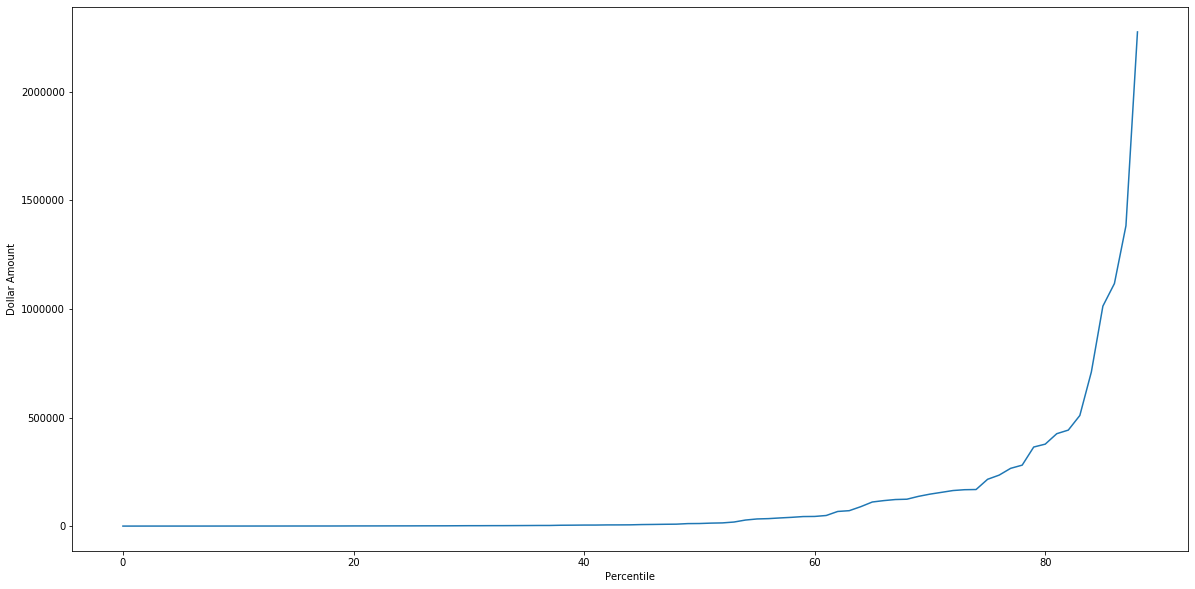

To obtain a Gold membership, you need to spend: $366886.19
To obtain a Silver membership, you need to spend: $59988.39
To obtain a Bronze membership, you need to spend: $4534.99


In [17]:
spending_amt_vals = []
for each in spending_amt.values():
    spending_amt_vals.append(each)

spending_array = np.array(spending_amt_vals)
spending_array.sort()
plt.figure(figsize=(20,10))
plt.plot(spending_array)
plt.xlabel("Percentile")
plt.ylabel("Dollar Amount")
plt.show()

spending_percentile_90 = np.percentile(spending_array, 90)
spending_percentile_70 = np.percentile(spending_array, 70)
spending_percentile_45 = np.percentile(spending_array, 45)
print("To obtain a Gold membership, you need to spend: $" + str(round(spending_percentile_90, 2)))
print("To obtain a Silver membership, you need to spend: $" + str(round(spending_percentile_70, 2)))
print("To obtain a Bronze membership, you need to spend: $" + str(round(spending_percentile_45, 2)))

### Stock Item Analysis & Forecast

Checking into how many units of a unique product was sold across the years.

In [18]:
stkisn_unique = clean.StkISN.unique()

In [19]:
date2015 = group_year("2015")         
stkisn2015 = {}

for i in date2015:
    key = clean.loc[i, "StkISN"]
    count = clean.loc[i, "Amt"] // clean.loc[i, "TUPrice"]
    for each in stkisn_unique:
        if key == each:
            if key not in stkisn2015:
                stkisn2015[each] = count
            else:
                stkisn2015[each] += count

for key, value in stkisn2015.items():
    if np.isnan(value):
        stkisn2015[key] = 0
        
stkisn2015_df = pd.DataFrame.from_dict(stkisn2015, orient = 'index')
stkisn2015_df.index.name = "StkISN"

In [20]:
date2016 = group_year("2016")         
stkisn2016 = {}

for i in date2016:
    key = clean.loc[i, "StkISN"]
    count = clean.loc[i, "Amt"] // clean.loc[i, "TUPrice"]
    for each in stkisn_unique:
        if key == each:
            if key not in stkisn2016:
                stkisn2016[each] = count
            else:
                stkisn2016[each] += count

for key, value in stkisn2016.items():
    if np.isnan(value):
        stkisn2016[key] = 0
        
stkisn2016_df = pd.DataFrame.from_dict(stkisn2016, orient = 'index')
stkisn2016_df.index.name = "StkISN"

In [21]:
date2017 = group_year("2017")         
stkisn2017 = {}

for i in date2017:
    key = clean.loc[i, "StkISN"]
    count = clean.loc[i, "Amt"] // clean.loc[i, "TUPrice"]
    for each in stkisn_unique:
        if key == each:
            if key not in stkisn2017:
                stkisn2017[each] = count
            else:
                stkisn2017[each] += count

for key, value in stkisn2017.items():
    if np.isnan(value):
        stkisn2017[key] = 0
        
stkisn2017_df = pd.DataFrame.from_dict(stkisn2017, orient = 'index')
stkisn2017_df.index.name = "StkISN"

In [22]:
date2018 = group_year("2018")         
stkisn2018 = {}

for i in date2018:
    key = clean.loc[i, "StkISN"]
    count = clean.loc[i, "Amt"] // clean.loc[i, "TUPrice"]
    for each in stkisn_unique:
        if key == each:
            if key not in stkisn2018:
                stkisn2018[each] = count
            else:
                stkisn2018[each] += count

for key, value in stkisn2018.items():
    if np.isnan(value):
        stkisn2018[key] = 0
        
stkisn2018_df = pd.DataFrame.from_dict(stkisn2018, orient = 'index')
stkisn2018_df.index.name = "StkISN"

In [23]:
date2019 = group_year("2019")         
stkisn2019 = {}

for i in date2019:
    key = clean.loc[i, "StkISN"]
    count = clean.loc[i, "Amt"] // clean.loc[i, "TUPrice"]
    for each in stkisn_unique:
        if key == each:
            if key not in stkisn2019:
                stkisn2019[each] = count
            else:
                stkisn2019[each] += count

for key, value in stkisn2019.items():
    if np.isnan(value):
        stkisn2019[key] = 0
        
stkisn2019_df = pd.DataFrame.from_dict(stkisn2019, orient = 'index')
stkisn2019_df.index.name = "StkISN"

In [24]:
# Combining the yearly data into a dataframe with the StockISN as the index

all_stkisn_df1 = pd.merge(stkisn2018_df, stkisn2019_df, how = "outer", on = "StkISN")
all_stkisn_df2 = pd.merge(stkisn2016_df, stkisn2017_df, how = "outer", on = "StkISN")
all_stkisn_df3 = pd.merge(all_stkisn_df2, all_stkisn_df1, how = "outer", on = "StkISN")
all_stkisn_df = pd.merge(stkisn2015_df, all_stkisn_df3, how = "outer", on = "StkISN")

all_stkisn_df.columns = ["2015", "2016", "2017", "2018", "2019"]
all_stkisn_df = all_stkisn_df.sort_values(by = "2019", ascending = False)
display(all_stkisn_df) # Sorted in descending order starting from the most popular producg

,2015,2016,2017,2018,2019
StkISN,,,,,
43513,0.0,0.0,0.0,32322.0,10743.0
43514,14578.0,5792.0,6748.0,0.0,10349.0
42533,NaN,NaN,NaN,9897.0,10199.0
43519,3450.0,2500.0,1549.0,4761.0,9949.0
43520,2992.0,795.0,4893.0,0.0,9646.0
...,...,...,...,...,...
47108,NaN,NaN,NaN,3787.0,NaN
47106,NaN,NaN,NaN,3761.0,NaN
10643,NaN,NaN,NaN,40.0,NaN


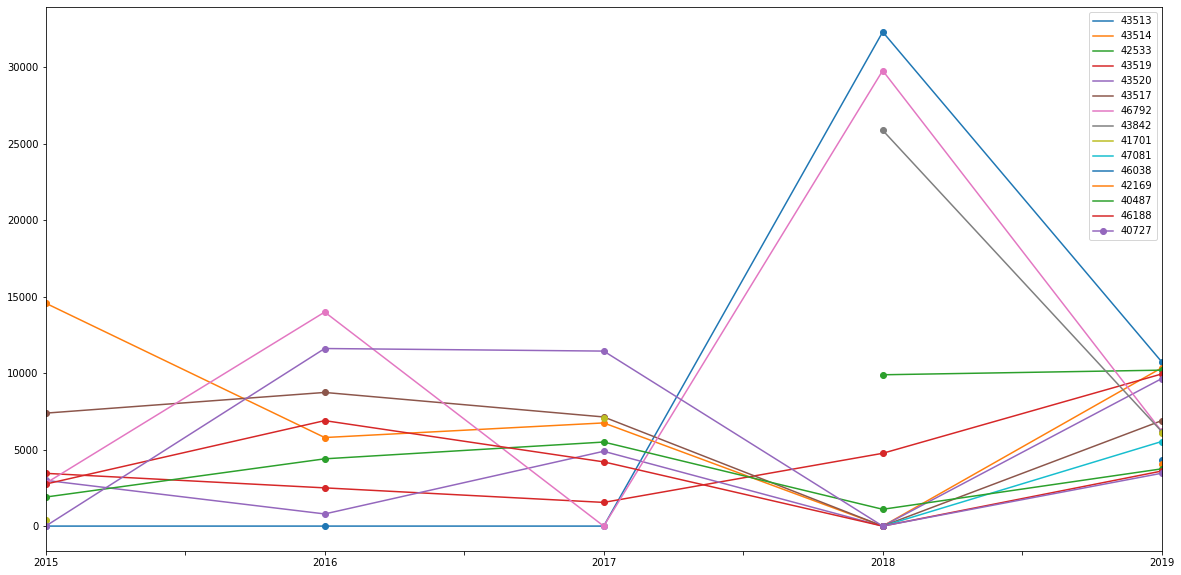

In [25]:
# Visualisation of the overall trends for the 15 most popular products

for each in all_stkisn_df.head(15).index:
    row = all_stkisn_df.loc[each]
    row.plot(marker = "o", legend = True, figsize = (20,10))

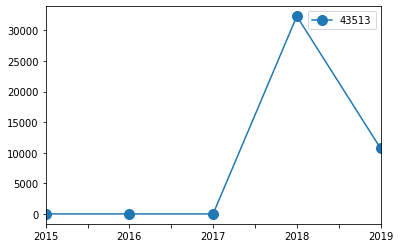

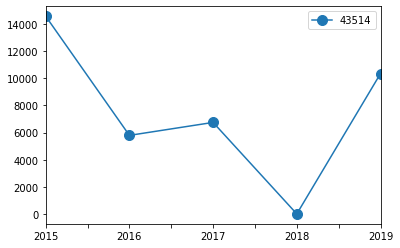

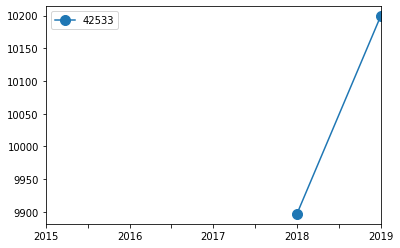

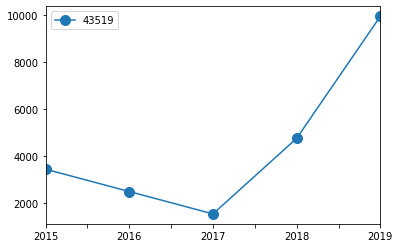

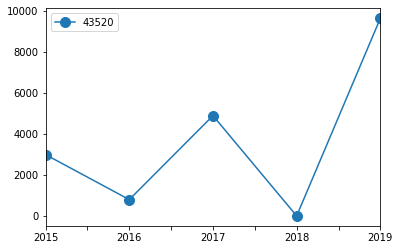

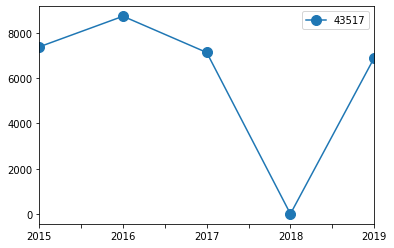

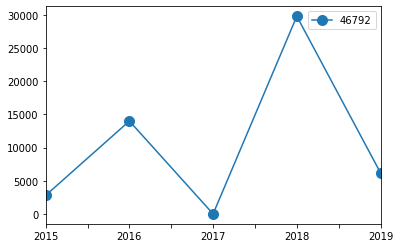

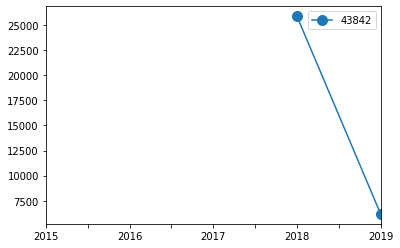

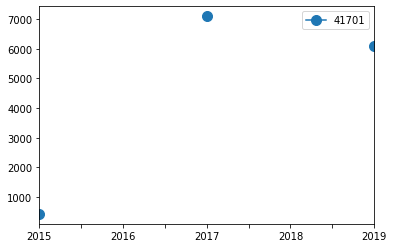

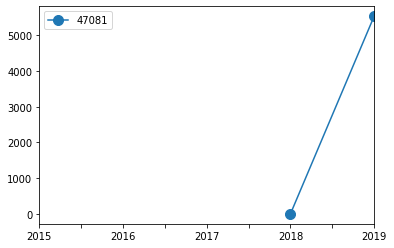

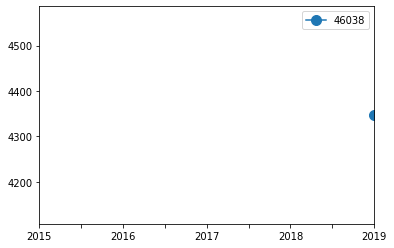

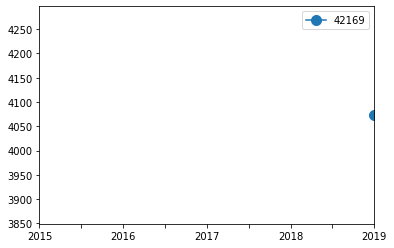

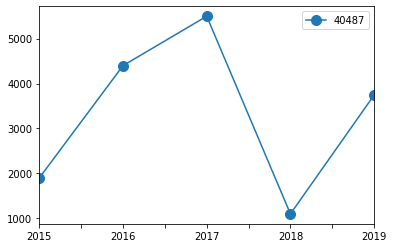

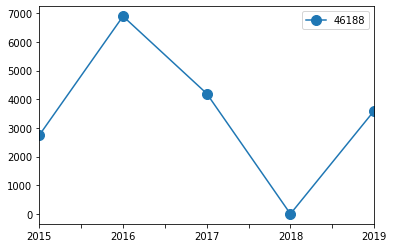

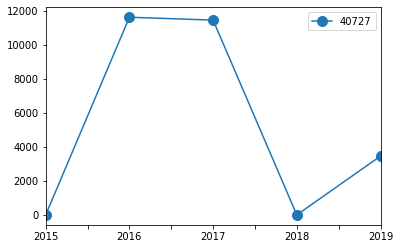

In [26]:
# Visualisation of the individual trends for the 15 most popular products

for each in all_stkisn_df.head(15).index:
    row = all_stkisn_df.loc[each]
    row = row.to_frame()
    row = row.assign(years = ["2015", "2016", "2017", "2018", "2019"])
    row.plot(kind = "line", marker = "o", ms = 10)

<a id='3.2'><h3>3.2 Forecast</h3></a>

Creating a 4-quarter running moving average forecast to help predict future demand & improve inventory management.

In [27]:
# Sort by quarter, year

q_month = {"Q1": ["01", "02", "03"], "Q2": ["04", "05", "06"], "Q3": ["07", "08", "09"], "Q4": ["10", "11", "12"]}

def group_qyear(quarter, year):
    group_qyearlist = []
    for i in range(len(clean)):
        if clean.loc[i, "Date"][6:] == year and clean.loc[i, "Date"][3:5] in q_month[quarter]:
            if i not in group_qyearlist:
                group_qyearlist.append(i)
                
    return group_qyearlist

In [28]:
q2_2018 = group_qyear("Q2", "2018")         
maq2_2018 = {}

for i in q2_2018:
    key = clean.loc[i, "StkISN"]
    count = clean.loc[i, "Amt"] // clean.loc[i, "TUPrice"]
    for each in stkisn_unique:
        if key == each:
            if key not in maq2_2018:
                maq2_2018[each] = count
            else:
                maq2_2018[each] += count

for key, value in maq2_2018.items():
    if np.isnan(value):
        maq2_2018[key] = 0
        
maq2_2018_df = pd.DataFrame.from_dict(maq2_2018, orient = 'index')
maq2_2018_df.index.name = "StkISN"

In [29]:
q3_2018 = group_qyear("Q3", "2018")         
maq3_2018 = {}

for i in q3_2018:
    key = clean.loc[i, "StkISN"]
    count = clean.loc[i, "Amt"] // clean.loc[i, "TUPrice"]
    for each in stkisn_unique:
        if key == each:
            if key not in maq3_2018:
                maq3_2018[each] = count
            else:
                maq3_2018[each] += count

for key, value in maq3_2018.items():
    if np.isnan(value):
        maq3_2018[key] = 0
        
maq3_2018_df = pd.DataFrame.from_dict(maq3_2018, orient = 'index')
maq3_2018_df.index.name = "StkISN"

In [30]:
q4_2018 = group_qyear("Q4", "2018")         
maq4_2018 = {}

for i in q4_2018:
    key = clean.loc[i, "StkISN"]
    count = clean.loc[i, "Amt"] // clean.loc[i, "TUPrice"]
    for each in stkisn_unique:
        if key == each:
            if key not in maq4_2018:
                maq4_2018[each] = count
            else:
                maq4_2018[each] += count

for key, value in maq4_2018.items():
    if np.isnan(value):
        maq4_2018[key] = 0
        
maq4_2018_df = pd.DataFrame.from_dict(maq4_2018, orient = 'index')
maq4_2018_df.index.name = "StkISN"

In [31]:
q1_2019 = group_qyear("Q1", "2019")         
maq1_2019 = {}

for i in q1_2019:
    key = clean.loc[i, "StkISN"]
    count = clean.loc[i, "Amt"] // clean.loc[i, "TUPrice"]
    for each in stkisn_unique:
        if key == each:
            if key not in maq1_2019:
                maq1_2019[each] = count
            else:
                maq1_2019[each] += count

for key, value in maq1_2019.items():
    if np.isnan(value):
        maq1_2019[key] = 0
        
maq1_2019_df = pd.DataFrame.from_dict(maq1_2019, orient = 'index')
maq1_2019_df.index.name = "StkISN"

In [32]:
all_forecast_df1 = pd.merge(maq2_2018_df, maq3_2018_df, how = "outer", on = "StkISN")
all_forecast_df2 = pd.merge(maq4_2018_df, maq1_2019_df, how = "outer", on = "StkISN")
all_forecast_df = pd.merge(all_forecast_df1, all_forecast_df2, how = "outer", on = "StkISN")

all_forecast_df.columns = ["Q2_2018", "Q3_2018", "Q4_2018", "Q1_2019"]
all_forecast_df = all_forecast_df.sort_values(by = "Q1_2019", ascending = False)
all_forecast_df["Q2_2019*"] = round(all_forecast_df.iloc[:, -4:].mean(axis = 1))
all_forecast_df["Q3_2019*"] = round(all_forecast_df.iloc[:, -4:].mean(axis = 1))
all_forecast_df["Q4_2019*"] = round(all_forecast_df.iloc[:, -4:].mean(axis = 1))
all_forecast_df["Q1_2020*"] = round(all_forecast_df.iloc[:, -4:].mean(axis = 1))
display(all_forecast_df) # *Forecasted values

,Q2_2018,Q3_2018,Q4_2018,Q1_2019,Q2_2019*,Q3_2019*,Q4_2019*,Q1_2020*
StkISN,,,,,,,,
10126,0.0,0.0,0.0,24628.0,6157.0,7696.0,9620.0,12025.0
43514,5300.0,250.0,0.0,10199.0,3937.0,3596.0,4433.0,5541.0
42533,449.0,NaN,4799.0,10199.0,5149.0,6716.0,6716.0,7195.0
43513,7993.0,7742.0,6993.0,9994.0,8180.0,8227.0,8348.0,8687.0
43519,200.0,NaN,4461.0,9949.0,4870.0,6427.0,6427.0,6918.0
...,...,...,...,...,...,...,...,...
10643,NaN,NaN,40.0,NaN,40.0,40.0,40.0,40.0
47078,NaN,NaN,901.0,NaN,901.0,901.0,901.0,901.0
42657,NaN,NaN,60.0,NaN,60.0,60.0,60.0,60.0


<a id='3.3'><h3>3.3 Command Line</h3></a>

Creating a user interface for employees to easily extract past data & forecast future values.

In [34]:
clean_type = list(clean.Type.unique())
clean_type.append("")

clean_refno = list(clean.RefNo.unique())
clean_refno = [str(i) for i in clean_refno]
clean_refno.append("")

clean_cust = list(clean.Customer.unique())
clean_cust.append("")

clean_isn = list(clean.StkISN.unique())
clean_isn = [str(i) for i in clean_isn]
clean_isn.append("")

clean_catcode = list(clean.CatCode.unique())
clean_catcode.append("")

In [35]:
# Defining functions to get information

def get_country():
    country = input("""Which region would you want to select?
[S] Singapore [M] Malaysia [I] Indonesia [A] Australia [F] Finland """).upper()
    while country not in ["S","M","I","A","F",""]:
        country = input("""Error, please try again. Which region would you want to select?
[S] Singapore [M] Malaysia [I] Indonesia [A] Australia [F] Finland """).upper()
    if country == "":
        country = "NA"
    return country

def get_isn():
    isn = input("Please input stockISN: ")
    while isn not in clean_isn:
        isn = input("Error, please try again. Please input stockISN: ")
    if isn == "":
        isn = "NA"
    return isn

def get_catcode():
    catcode = input("Please input category code: ").upper()
    while catcode not in clean_catcode:
        catcode = input("Error, please try again. Please input category code: ").upper()
    if catcode == "":
        catcode = "NA"
    return catcode
            
def get_refno():
    refno = input("Please input reference number: ")
    while refno not in clean_refno:
        refno = input("Error, please try again. Please input reference number: ")
    if refno == "":
        refno = "NA"
    return refno

def get_date():
    year = input("Please input year (yyyy): ")
    if year == "":
        year = "NA"
    else:
        while len(year) != 4 or year.isnumeric() is False:
            year = input("Error, please try again. Please input year (yyyy): ")
            if year == "":
                year = "NA"
                break
            
    month = input("Please input month (mm): ")
    if month == "":
        month = "NA"
    else:
        while len(month) != 2 or month.isnumeric() is False:
            month = input("Error, please try again. Please input month (mm): ")
            if month == "":
                month = "NA"
                break
            
    day = input("Please input day (dd): ")
    if day == "":
            day = "NA"
    else:
        while len(day) != 2 or day.isnumeric() is False:
            day = input("Error, please try again. Please input day (dd): ")
            if day == "":
                day = "NA"
                break
            
    return day, month, year

def get_cust():
    cust = input("Please input customer ID: ").upper()
    while cust not in clean_cust:
        cust = input("Error, please try again. Please input customer ID: ")
    if cust == "":
        cust = "NA"
    return cust

def get_type():
    typ = input("Please input transaction type [ICG, ICX]: ").upper()
    while typ not in clean_type:
        typ = input("Error, please try again. Please input transaction type [ICG, ICX]: ").upper()
    if typ == "":
        typ = "NA"
    return typ

def get_amt_range():
    min_amt = 1.0
    max_amt = 0.0
    while float(min_amt) > float(max_amt):
        min_amt = input("Please input minimum amount: ") 
        if min_amt == "":
            min_amt = "NA"
        else:
            while min_amt.replace(".", "",1).isdigit() is False:
                min_amt = input("Error, please try again. Please input minimum amount: ")
                if min_amt == "":
                    min_amt = "NA"
                    break    

        max_amt = input("Please input maximum amount: ")
        if max_amt == "":
            max_amt = "NA"
        else:
            while max_amt.replace(".", "",1).isdigit() is False:
                max_amt = input("Error, please try again. Please input maximum amount: ")
                if max_amt == "":
                    max_amt = "NA"
                    break  

        if min_amt == "NA" or max_amt == "NA":
            break
            
    return min_amt, max_amt

In [36]:
def get_info():
    info = []
    info.append(get_date())
    info.append(get_type())
    info.append(get_refno())
    info.append(get_amt_range())
    info.append(get_country())
    info.append(get_isn())
    info.append(get_catcode())
    info.append(get_cust())
    
    return info

In [37]:
# Defining function to filter according to date

def filter_date():
    for i in range(len(clean)):
        date = "{}/{}/{}".format(info[0][0], info[0][1], info[0][2])
        day = date[:2]
        month = date[3:5]
        year = date[6:]
        if year != "NA":
            if month != "NA":
                if day != "NA":
                    if clean.loc[i, "Date"] == date:
                        if i not in data:
                            data.append(i)
                else:
                    if clean.loc[i, "Date"][3:] == date[3:]:
                        if i not in data:
                            data.append(i)
            else:
                if clean.loc[i, "Date"][6:] == year:
                    if i not in data:
                        data.append(i)
        elif year == "NA" and month != "NA":
            if day != "NA":
                if clean.loc[i, "Date"][:6] == date[:6]:
                    if i not in data:
                        data.append(i)
            else:
                if clean.loc[i, "Date"][3:5] == date[3:5]:
                    if i not in data:
                        data.append(i)
        else:
            data.append(i)

            
# Defining function to filter according to transaction type

def filter_type():
    type_list = []
    data_temp = []
    global data
    if info[1] != "NA":
        for i in range(len(clean)):
            if info[1] == str(clean.loc[i, "Type"]):
                type_list.append(i)
        for each in type_list:
            if each in data:
                data_temp.append(each)
        data = data_temp.copy()
            
            
# Defining function to filter according to reference number

def filter_refno():
    refno_list = []
    data_temp = []
    global data
    if info[2] != "NA":
        for i in range(len(clean)):
            if info[2] == str(clean.loc[i, "RefNo"]):
                refno_list.append(i)
        for each in refno_list:
            if each in data:
                data_temp.append(each)
        data = data_temp.copy()
        
        
# Defining function to filter according to amount

def filter_amt():
    amt_list = []
    data_temp = []
    global data
    if info[3][0] != "NA" and info[3][1] != "NA":
        for i in range(len(clean)):
            if float(clean.loc[i, "Amt"]) > float(info[3][0]) and float(clean.loc[i, "Amt"]) < float(info[3][1]):
                amt_list.append(i)
        for each in amt_list:
            if each in data:
                data_temp.append(each)
        data = data_temp.copy()
    elif info[3][0] != "NA" and info[3][1] == "NA":
        for i in range(len(clean)):
            if float(clean.loc[i, "Amt"]) > float(info[3][0]):
                amt_list.append(i)
        for each in amt_list:
            if each in data:
                data_temp.append(each)
        data = data_temp.copy()
    elif info[3][0] == "NA" and info[3][1] != "NA":
        for i in range(len(clean)):
            if float(clean.loc[i, "Amt"]) < float(info[3][1]):
                amt_list.append(i)
        for each in amt_list:
            if each in data:
                data_temp.append(each)
        data = data_temp.copy()

        
# Defining function to filter according to country

def filter_country():
    country_list = []
    data_temp = []
    global data
    if info[4] != "NA":
        for i in range(len(clean)):
            if info[4] == str(clean.loc[i, "Customer"][0]):
                country_list.append(i)
        for each in country_list:
            if each in data:
                data_temp.append(each)
        data = data_temp.copy()
        
        
# Defining function to filter according to stockISN

def filter_isn():
    isn_list = []
    data_temp = []
    global data
    if info[5] != "NA":
        for i in range(len(clean)):
            if info[5] == str(clean.loc[i, "StkISN"]):
                isn_list.append(i)
        for each in isn_list:
            if each in data:
                data_temp.append(each)
        data = data_temp.copy()
        
        
# Defining function to filter according to category code

def filter_catcode():
    catcode_list = []
    data_temp = []
    global data
    if info[6] != "NA":
        for i in range(len(clean)):
            if info[6] == str(clean.loc[i, "CatCode"]):
                catcode_list.append(i)
        for each in catcode_list:
            if each in data:
                data_temp.append(each)
        data = data_temp.copy()
        
        
# Defining function to filter according to customer

def filter_cust():
    cust_list = []
    data_temp = []
    global data
    if info[7] != "NA":
        for i in range(len(clean)):
            if info[7] == str(clean.loc[i, "Customer"]):
                cust_list.append(i)
        for each in cust_list:
            if each in data:
                data_temp.append(each)
        data = data_temp.copy()

In [38]:
def filter_all():
    filter_date()
    filter_type()
    filter_refno()
    filter_amt()
    filter_country()
    filter_isn()
    filter_catcode()
    filter_cust()

In [39]:
def filter_results():
    filter_all()
    print("""
    
==================================== Results ====================================
    
    """)
    if len(data) == 0:
        print("There are no results for the search.")

In [40]:
def stats_analysis():
    column_headings = ["Date", "Type", "RefNo", "SNO", "Cur", "TUPrice", "Amt", "Customer","StkISN", "CatCode"]
    new = []
    for each in data:
        new.append(clean.loc[[each]])
    new_df = pd.concat(new) 
    new_df.reset_index(inplace = True)
    return new_df

def proportions():
    global new_df
    %matplotlib inline
    fig, axs = plt.subplots(2, 2, figsize = (20,10))
    
    country = {}
    for index in range(len(new_df)):
        key =  new_df.loc[index, "Customer"][0]
        if key not in country:
            country[key] = 1
        else:
            country[key] += 1
    axs[0,0].pie(country.values(), labels = country.keys(), autopct='%1.1f%%', shadow=True, textprops = {"fontsize" : 20})
    axs[0, 0].set_title("Proportion of Customers in Each Country")

    type_count = {}
    for index in range(len(new_df)):
        key =  new_df.loc[index, "Type"]
        if key not in type_count:
            type_count[key] = 1
        else:
            type_count[key] += 1
    axs[0,1].pie(type_count.values(), labels = type_count.keys(), autopct='%1.1f%%', shadow=True, textprops = {"fontsize" : 20})
    axs[0, 1].set_title("Proportion of Customers' Transaction Type")

    cust_count = {}
    for index in range(len(new_df)):
        key =  new_df.loc[index, "Customer"]
        if key not in cust_count:
            cust_count[key] = 1
        else:
            cust_count[key] += 1
    axs[1,0].bar(cust_count.keys(), cust_count.values())
    axs[1,0].set_title("Number of Transactions per Customer")


    catcode_count = {}
    for index in range(len(new_df)):
        key =  new_df.loc[index, "CatCode"]
        if key not in catcode_count:
            catcode_count[key] = 1
        else:
            catcode_count[key] += 1
    axs[1,1].bar(catcode_count.keys(), catcode_count.values())
    axs[1,1].set_title("Number of Transactions per Category Code")

    plt.show()

Hello, welcome. I am here to assist you in your queries. 
Kindly allow me to assist you in providing information you require.

I would need you to input information necessary to filter the data. 
If no entry is required for that field, please just press [Enter] and leave that field empty.

    
Please input year (yyyy): 2019
Please input month (mm): 04
Please input day (dd): 04
Please input transaction type [ICG, ICX]: 
Please input reference number: 
Please input minimum amount: 
Please input maximum amount: 
Which region would you want to select?
[S] Singapore [M] Malaysia [I] Indonesia [A] Australia [F] Finland 
Please input stockISN: 
Please input category code: 
Please input customer ID: 

    
==================================== Results ====================================
    
    
    index        Date Type   RefNo  SNO Cur  TUPrice      Amt Customer  \
0   24245  04/04/2019  ICG  137239    1  S$      4.6   230.00     IA14   
1   24246  04/04/2019  ICG  137239    2  S$      2.

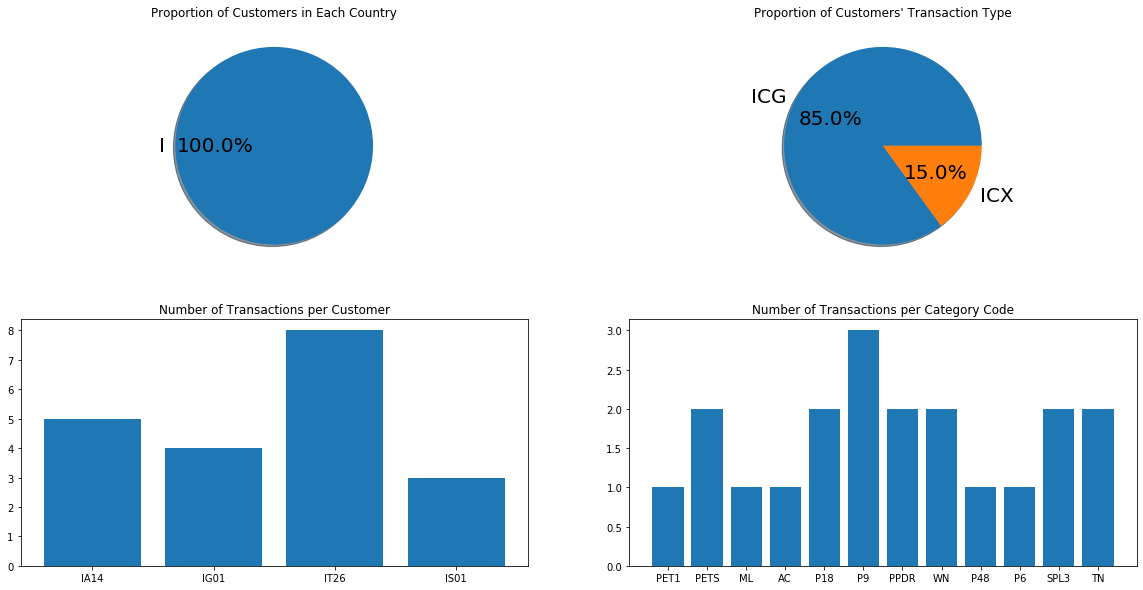

------------------ End of Search ------------------
    
    
Please input StkISN to get forecasted quantity for the next quarter.
If forecast is not required, press [Enter]: y
Error, please try again. Please input stockISN: 45443
Forecast:  30.0
Would you like to search for another forecast? [Y/N]n
Would you like to do another search? [Y/N]n
Thank you. Have a nice day!


In [43]:
cont_search = "Y"
cont_forecast = "Y"

while cont_search == "Y":
    print("""Hello, welcome. I am here to assist you in your queries. 
Kindly allow me to assist you in providing information you require.

I would need you to input information necessary to filter the data. 
If no entry is required for that field, please just press [Enter] and leave that field empty.

    """)

    info = get_info()
    data = []
    filter_results()
    new_df = stats_analysis()
    print(new_df)
    print("""
    
==================================== Statistical Summary ====================================
          
------------------ TUPrice Summary ------------------""")
    print(new_df["TUPrice"].describe())
    print("""
    
------------------ Amt Summary ------------------""")
    print(new_df["Amt"].describe())
    print("""
    
------------------ Visualisation ------------------

""")
    proportions()
    print("""------------------ End of Search ------------------
    
    """)
        
    while cont_forecast == "Y":
        forecast_stkisn = input("""Please input StkISN to get forecasted quantity for the next quarter.
If forecast is not required, press [Enter]: """)
        while forecast_stkisn not in clean_isn:
            forecast_stkisn = input("Error, please try again. Please input stockISN: ")
        if forecast_stkisn != "":
            print("Forecast: ", all_forecast_df.loc[int(forecast_stkisn), "Q2_2019*"])
            cont_forecast = input("Would you like to search for another forecast? [Y/N]").upper()
            while cont_forecast != "Y" and cont_forecast != "N":
                cont_forecast = input("Entry error. Would you like to search for another forecast? [Y/N]").upper()
        else:
            break
    
    cont_search = input("Would you like to do another search? [Y/N]").upper()
    while cont_search != "Y" and cont_search != "N":
        cont_search = input("Entry error. Would you like to do another search? [Y/N]").upper()
    print("Thank you. Have a nice day!")

# END